In [2]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from tensorflow.keras.preprocessing import image_dataset_from_directory#,image
from sklearn.model_selection import train_test_split
import glob
import cv2 as cv


## Declaración de variables

In [3]:
lado_mapa = 5
periodo = 3000
learning_rate = 0.0015

num_entradas = 1
num_datos = 100
dimensiones=[130,130]

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario = lado_mapa/2


matriz_pesos = np.random.random((lado_mapa,lado_mapa,dimensiones[0],dimensiones[1]))

## Obtención y procesamiento de las imagenes

In [4]:

image_list = []#array que contendrá todas las imagenes

#obtenemos las parasitadas
for filename in glob.glob('cell_images\cell_images\Parasitized\*.png'): #obtenemos los nombres de todas las imagenes 
    im=cv.imread(filename, cv.IMREAD_UNCHANGED)/255
    im=cv.resize(im,dimensiones,interpolation=cv.INTER_AREA)
    image_list.append(im)
#obtenemos las no infectadas
for filename in glob.glob(r'cell_images\cell_images\Uninfected\*.png'): #obtenemos los nombres de todas las imagenes
    im=cv.imread(filename, cv.IMREAD_UNCHANGED)/255
    im=cv.resize(im,dimensiones,interpolation=cv.INTER_AREA)
    image_list.append(im)



In [5]:

#utilizaremos esta funcion para mezclar los valores de la lista de imagenes y asi no estén juntas por la clase a la que pertenecen
def mezclar_lista(lista_original):
    lista = lista_original[:]
    longitud_lista = len(lista)

    for i in range(longitud_lista):
        aleatorio = np.random.randint(0, longitud_lista - 1)
        # Intercambiar
        aux = lista[i]
        lista[i] = lista[aleatorio]
        lista[aleatorio] = aux
    # Regresarla
    return lista


lista=np.array(mezclar_lista(image_list))
#dividimos en 2 el dataset para valores de entrenamiento y valores de clasificación
x_train, x_resto= train_test_split(lista, test_size=0.3, shuffle=True)

print(len(x_train), len(x_resto))

19290 8268


In [25]:
lado_mapa = 5
periodo = 1000
learning_rate = 0.1

matriz_pesos = np.random.random((lado_mapa,lado_mapa,dimensiones[0],dimensiones[1],3))

## Definicion de funciones

In [26]:
#93.39152381238563
#Función para calcular la distancia euclidea
def distancia(patron, peso):
    #distancia=0
    #comp=0
    #peso=peso.flatten()
    #
    #for i in range(patron.shape[0]):
    #    #for j in range(patron.shape[1]):
    #        #for k in range(patron.shape[2]):
    #    comp+=(peso[i]-patron[i])**2
    #    #print(i)
    #distancia=(comp)**0.5
    a=np.square(np.subtract(patron,peso))
    b=np.sum(a)
    distancia=np.sqrt(b)
    return distancia

# Función para encontrar la BMU
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
"""
def calcular_bmu(patron_entrada, m_pesos, m):
    MenorDist=0
    MejorVector=[]
    a=[]
    Resultado=0
    idx=[]
    b=0
    
    for i in range(m):
        for j in range(m):
            #print(b)
            a=m_pesos[i][j]
            Resultado=distancia(patron_entrada, a)#distancia euclidea
            #print("Neurona: ", Resultado)
            if i == 0 and j==0 :#salvamos la primera iteracion
                MenorDist=Resultado
                MejorVector=m_pesos[i][j]
                idx=[i,j]
            else:
                #si encuentra una distancia euclidea menor cambiamos
                if MenorDist>Resultado:
                    #print(m_pesos[i][j])
                    MenorDist=Resultado
                    MejorVector=m_pesos[i][j]
                    idx=[i,j]
            b+=1        
 
    return MejorVector,idx



# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
def variacion_learning_rate(lr_inicial, i, n_iteraciones):
    
    #lr_final = lr_inicial * (1 - i/n_iteraciones) 
    learning_rate = lr_inicial + (-lr_inicial/n_iteraciones)*i
    return learning_rate

#función para ajustar los pesos durante el entrenamiento
def ajuste_Pesos(i,j,pesos):
    total=0
    for a in range(dimensiones[0]):
        #for b in range(dimensiones[1]):
        total+=pesos[i][j][a]**2
    return (total)**0.5


# Función para calcular el descenso del vecindario (v)
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
def variacion_vecindario(vecindario_inicial, i, n_iteraciones):
    
    vecindario_i = 1 + vecindario_inicial * (1 - i/n_iteraciones)
    return vecindario_i

# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    return np.exp(-distancia_BMU**2 / (2*vecindario_actual**2))

In [27]:
x_train[5].shape

(130, 130, 3)

## Entrenamiento

In [17]:
# Entrena la red con el dataset de entrenamiento

for i in range(periodo):
    azar=np.random.randint(0, len(x_train)) 
    patron=x_train[azar]#patron al azar
    #patron=np.reshape(patron,(dimensiones[0],dimensiones[1]))
    BMU, coordenadas = calcular_bmu(patron, matriz_pesos, lado_mapa)#encontramos la bmu y sus coordenadas
    eta=variacion_learning_rate(learning_rate, i+1, periodo)#calculamos eta
    v=variacion_vecindario(vecindario, i+1, periodo)#calculamos el vecindario
    
    #comprobamos cuales son las neuronas del vecindario de la BMU y les aplicamos el aprendizaje que les corresponde
    for w in range(len(matriz_pesos)):
        for j in range(len(matriz_pesos)):
            deu= ((w-coordenadas[0])**2 + (j-coordenadas[1])**2 )**0.5 #calculamos la distancia del peso a la BMU
            
            if deu <= v :
                amortiguacion= decay(deu, v) #calculamos la amortiguacion
                matriz_pesos[w][j]= matriz_pesos[w][j]/ajuste_Pesos(w,j,matriz_pesos)#ajustamos el peso
                matriz_pesos[w][j]= matriz_pesos[w][j] + eta*amortiguacion*(patron-matriz_pesos[w][j]) #aplicamos aprendizaje
    if i%100==0:
        print("Vuelta nº: ", i)

Vuelta nº:  0
Vuelta nº:  100
Vuelta nº:  200
Vuelta nº:  300
Vuelta nº:  400
Vuelta nº:  500
Vuelta nº:  600
Vuelta nº:  700
Vuelta nº:  800
Vuelta nº:  900
Vuelta nº:  1000
Vuelta nº:  1100
Vuelta nº:  1200
Vuelta nº:  1300
Vuelta nº:  1400
Vuelta nº:  1500
Vuelta nº:  1600
Vuelta nº:  1700
Vuelta nº:  1800
Vuelta nº:  1900
Vuelta nº:  2000
Vuelta nº:  2100
Vuelta nº:  2200
Vuelta nº:  2300
Vuelta nº:  2400
Vuelta nº:  2500
Vuelta nº:  2600
Vuelta nº:  2700
Vuelta nº:  2800
Vuelta nº:  2900


In [18]:
#Función para calcular la distancia euclidea

#Funcion para calcular el error de cuantificacion aplicando su formula
def errorCuantificacion(dis):
    contador = 0
    error_cuantificacion = 0
    
    for j in range(dis.shape[0]):
        for k in range(dis.shape[1]):
            if dis[j][k] != 0:
                contador+=1
                error_cuantificacion += dis[j][k]
                
    error_cuantificacion = error_cuantificacion / contador
    return error_cuantificacion


#Funcion para calcular el error topológico aplicando su formula
def errorTopologico(bmu1, bmu2):
    if ((bmu2[0] == bmu1[0] + 1 or bmu2[0] == bmu1[0] - 1) and bmu2[1] == bmu1[1]) or (bmu2[0] == bmu1[0] and (bmu2[1] == bmu1[1] + 1 or bmu2[1] == bmu1[1] - 1)) or ((bmu2[0] == bmu1[0] - 1) and (bmu2[1] == bmu1[1] + 1 or bmu2[1] == bmu1[1] - 1)) or ((bmu2[0] == bmu1[0] + 1) and (bmu2[1] == bmu1[1] + 1 or bmu2[1] == bmu1[1] - 1)):
        v = 0
    else:
        v = 1
    return v

#Calcular la segunda BMU
def calcular2bmu(patron_entrada, m_pesos, m):
    MenorDist = 999999
    MenorDist2 = 999999
    MejorVector  =  [0,0,0]
    MejorVector2  =  [0,0,0]
    a=[]
    Resultado = 0
    idx=[]
    idx2=[]
    
    for i in range(len(m_pesos[0])):
        for j in range(len(m_pesos[1])):
            a = m_pesos[i][j]
            Resultado = distancia(patron_entrada,a)
            #print(i,j)
            if Resultado< MenorDist:
                #cambiamos la antigua mejor a la segunda mejor
                MenorDist2=MenorDist
                MejorVector2 = MejorVector
                idx2 = idx
                
                #actualizamos la mejor
                MenorDist=Resultado
                MejorVector = m_pesos[i][j]
                idx = [i,j]
                #print(idx,idx2)
                #print(MenorDist, MenorDist2)
            elif Resultado<MenorDist2:
                MenorDist2=Resultado
                MejorVector2 = m_pesos[i][j]
                idx2 = [i,j]

     


    return MejorVector,idx,MejorVector2, idx2



In [19]:
def error_top(bmu1,bmu2):
    v=0
    d=((bmu1[0]-bmu2[0])**2+(bmu1[1]-bmu2[1])**2)**0.5
    
    if d>2**0.5:
        v=1
    else:
        v=0
    return v



In [20]:
len(x_resto)

8268

In [21]:
#Clasificacion los datos
clasificacion = np.zeros((lado_mapa, lado_mapa, dimensiones[0],dimensiones[1],3))
activacion = np.zeros((lado_mapa, lado_mapa))
distancias = np.zeros((lado_mapa, lado_mapa))
suma = 0
clase = 0
eTopo = 0


#### --------------------   QUITAR EL PARTIDO 10 ------------------------------- #######################

for i in range(round(len(x_resto)/4)):
    patron=x_resto[i]#patron al azar
    #patron=np.reshape(patron,(dimensiones[0],dimensiones[1]))
    
    #BMU, coor = calcular_bmu(patron, matriz_pesos, lado_mapa) #BMU
    BMU, coor, BMU2, coor2 = calcular2bmu(patron, matriz_pesos, lado_mapa) #BMU2
    
    clasificacion[coor[0]][coor[1]] = x_resto[i]#asignamos el ultimo patron reconocido por la neurona
    activacion[coor[0]][coor[1]] += 1 #sumamos uno en la neurona activado
    distancias[coor[0]][coor[1]] = distancias[coor[0]][coor[1]] + distancia(patron, BMU) #distancia media 
    eTopo += error_top(coor, coor2) # sumamos el error topologico
    if i%100==0:
        print("Vueltas:", i)
    #Calculamos el numero de la clases y guardamos la distancia media de las neuronas asociadas
for g in range(activacion.shape[0]): 
    for t in range(activacion.shape[1]):
        if  activacion[g][t] > 0:
            clase+=1
            distancias[g][t]=distancias[g][t]/activacion[g][t] 
      
            
nclases = clase
mapa_activaciones = activacion
mapa_distancia = distancias
eCuanti = errorCuantificacion(distancias)
eTopo = eTopo/len(x_resto)



Vueltas: 0
Vueltas: 100
Vueltas: 200
Vueltas: 300
Vueltas: 400
Vueltas: 500
Vueltas: 600
Vueltas: 700
Vueltas: 800
Vueltas: 900
Vueltas: 1000
Vueltas: 1100
Vueltas: 1200
Vueltas: 1300
Vueltas: 1400
Vueltas: 1500
Vueltas: 1600
Vueltas: 1700
Vueltas: 1800
Vueltas: 1900
Vueltas: 2000
Mapa Distancias: 
 [[102.79417581 102.55069466  99.01298597 109.54469528 110.62005704]
 [105.98511657 100.77746086 106.40427137 106.8229184  110.40001313]
 [108.94586648 108.25613723 110.67756293 109.68829907 106.0955815 ]
 [107.41275645 103.87085477 109.54909343 107.74176206 110.26297768]
 [104.82211145 103.97630835 110.2857556  109.51798672 106.87200682]]
Mapa Activaciones: 
 [[112.   5.   3.  41. 111.]
 [ 10.  29.  40. 100.  27.]
 [147.  32.  82.  27. 234.]
 [ 69. 147.  30. 136.  36.]
 [111.  11. 359.   7. 161.]]
Clases: 25
Error Topologico: 0.12058538945331398
Error cuantificacion: 106.91549798502612
5
3000
0.2


In [24]:
print("Mapa Distancias: \n", mapa_distancia)
print("\nMapa Activaciones: \n", mapa_activaciones)
print("\nClases:", clase)
print("Error Topologico:", eTopo)
print("Error cuantificacion:", eCuanti)


print("\n",lado_mapa)
print(periodo)
print(learning_rate)

Mapa Distancias: 
 [[102.79417581 102.55069466  99.01298597 109.54469528 110.62005704]
 [105.98511657 100.77746086 106.40427137 106.8229184  110.40001313]
 [108.94586648 108.25613723 110.67756293 109.68829907 106.0955815 ]
 [107.41275645 103.87085477 109.54909343 107.74176206 110.26297768]
 [104.82211145 103.97630835 110.2857556  109.51798672 106.87200682]]

Mapa Activaciones: 
 [[112.   5.   3.  41. 111.]
 [ 10.  29.  40. 100.  27.]
 [147.  32.  82.  27. 234.]
 [ 69. 147.  30. 136.  36.]
 [111.  11. 359.   7. 161.]]

Clases: 25
Error Topologico: 0.12058538945331398
Error cuantificacion: 106.91549798502612

 5
3000
0.2


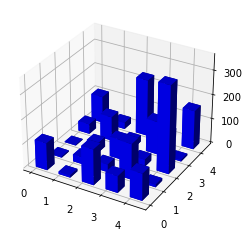

In [22]:
def histograma (mapa_activaciones):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xpos = [range(mapa_activaciones.shape[0])]
    ypos = [range(mapa_activaciones.shape[1])]
    xpos, ypos = np.meshgrid(xpos, ypos)
    xpos = xpos.flatten('F')
    ypos = ypos.flatten('F')
    zpos = np.zeros_like(xpos)

    dx = 0.5 * np.ones_like(zpos)
    dy = dx.copy()
    dz = mapa_activaciones.flatten()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b',   zsort='average')

    plt.show()

histograma(mapa_activaciones)